<a href="https://colab.research.google.com/github/trilgar/CNN_LSTM-heartbeat-classifier/blob/main/GAN_heartbeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import Sequence

from torch.utils.data import Dataset
import numpy as np
import pandas as pd


class Heartbeat(Dataset):
    def __init__(self, path='model/heartbeat1.csv'):
        self.dataset = pd.read_csv(path, sep=',', header=None)

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        return self.dataset.iloc[idx].values

In [ ]:
from torch import nn
from torch.nn.utils import spectral_norm


class AddDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)


class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)


def create_generator_architecture():
    return nn.Sequential(nn.Linear(50, 100),
                         nn.LeakyReLU(0.2, inplace=True),
                         AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.Upsample(200),

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Upsample(400),

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Upsample(800),

                         spectral_norm(nn.Conv1d(32, 1, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),

                         SqueezeDimension(),
                         nn.Linear(800, 187)
                         )


def create_critic_architecture():
    return nn.Sequential(AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.MaxPool1d(2),

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.MaxPool1d(2),

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Flatten(),

                         nn.Dropout(0.1)
                         )


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = create_generator_architecture()

    def forward(self, input):
        return self.main(input)


class Critic(nn.Module):
    def __init__(self, n_additional_features=0):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(1472 + n_additional_features, 50),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(50, 15),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(15, 1))
        self.main = create_critic_architecture()

    def forward(self, input, additional_features=None):
        out = self.main(input)
        return self.linear(out)


In [ ]:
import os

import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt


class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=20, use_cuda=False, checkpoint_frequency=200,
                 writer=None):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.checkpoint_frequency = checkpoint_frequency
        self.writer = writer

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, real_data):

        batch_size = real_data.size()[0]
        noise_shape = (batch_size, self.NOISE_LENGTH)
        generated_data = self.sample_generator(noise_shape)

        real_data = Variable(real_data)

        if self.use_cuda:
            real_data = real_data.cuda()

        # Pass data through the Critic
        c_real = self.c(real_data)
        c_generated = self.c(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(real_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        batch_size = data.size()[0]
        latent_shape = (batch_size, self.NOISE_LENGTH)

        generated_data = self.sample_generator(latent_shape)

        # Calculate loss and optimize
        d_generated = self.c(generated_data)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):

        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data.float())
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                self.writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                self.writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                self.writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)
                if self.num_steps > self.critic_iterations:
                    self.writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, epochs, plot_training_samples=True, checkpoint=None):
        real = data_loader.dataset[0]
        if checkpoint:
            path = os.path.join('/content/drive/MyDrive/diploma/working/checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])

        # Define noise_shape
        noise_shape = (1, self.NOISE_LENGTH)

        if plot_training_samples:
            # Fix latents to see how series generation improves during training
            fixed_latents = Variable(self.sample_latent(noise_shape))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()

        for epoch in tqdm(range(epochs)):

            # Sample a different region of the latent distribution to check for mode collapse
            dynamic_latents = Variable(self.sample_latent(noise_shape))
            if self.use_cuda:
                dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1)

            # Save checkpoint
            if epoch % self.checkpoint_frequency == 0:
                torch.save({
                    'epoch': epoch,
                    'd_state_dict': self.c.state_dict(),
                    'g_state_dict': self.g.state_dict(),
                    'd_opt_state_dict': self.c_opt.state_dict(),
                    'g_opt_state_dict': self.g_opt.state_dict(),
                }, '/content/drive/MyDrive/diploma/working/checkpoints/epoch_{}.pkl'.format(epoch))

            if plot_training_samples and (epoch % self.print_every == 0):
                self.g.eval()
                # Generate fake data using both fixed and dynamic latents
                fake_data_fixed_latents = self.g(fixed_latents).cpu().data
                fake_data_dynamic_latents = self.g(dynamic_latents).cpu().data

                generated = self.sample((1, self.NOISE_LENGTH))[0]

                plt.figure()
                plt.plot(generated, label='generated')
                plt.plot(real, label='real')
                plt.legend()
                plt.savefig('/content/drive/MyDrive/diploma/working/images/epoch_{}'.format(epoch))
                plt.close()

                plt.figure()
                plt.plot(fake_data_fixed_latents.numpy()[0].T)
                plt.savefig('/content/drive/MyDrive/diploma/working/training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
                plt.close()

                plt.figure()
                plt.plot(fake_data_dynamic_latents.numpy()[0].T)
                plt.savefig('/content/drive/MyDrive/diploma/working/training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
                plt.close()
                self.g.train()
        plt.figure()
        plt.plot(self.losses['g'], label='generator loss')
        plt.legend()
        plt.savefig('/content/drive/MyDrive/diploma/working/images/generator_loss.png')
        plt.close()

        plt.figure()
        plt.plot(self.losses['c'], label='critic loss')
        plt.legend()
        plt.savefig('/content/drive/MyDrive/diploma/working/images/critic_loss.png')
        plt.close()

    def sample_generator(self, latent_shape):
        latent_samples = Variable(self.sample_latent(latent_shape))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()

        return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


Training is about to start...


100%|██████████| 101/101 [24:58<00:00, 14.84s/it]


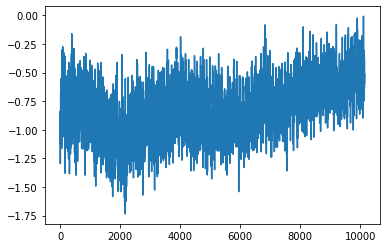

In [ ]:
import os
from math import pi

import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter

g = Generator()
g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
d = Critic()

d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)

# Create Dataloader
dataset = Heartbeat(path='/content/drive/MyDrive/diploma/heartbeat4.csv')
dataloader = DataLoader(dataset, batch_size=32)
writer = SummaryWriter()

# Instantiate Trainer
trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available(), writer=writer, checkpoint_frequency=100,
                  critic_iterations=2)
# Train model
print('Training is about to start...')
# Instantiate Tensorboard writer
checkpoint = './'
epochs = 101
trainer.train(dataloader, epochs=epochs, plot_training_samples=True, checkpoint='epoch_300.pkl')
writer.close()

plt.plot(trainer.losses['g'])
plt.show()


In [ ]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch.autograd import Variable
from IPython.display import display


class SampleGenerator:
    def __init__(self, generator, checkpoint):
        self.g = generator
        path = os.path.join('/content/drive/MyDrive/diploma/working/checkpoints', checkpoint)
        state_dicts = torch.load(path, map_location=torch.device('cpu'))
        self.g.load_state_dict(state_dicts['g_state_dict'])

    def generate_samples(self, num_samples=1, category=0):
        generated = self.sample((num_samples, 50))

        data = pd.DataFrame(generated)
        data[188] = np.array([category] * num_samples)
        return data

    def sample_generator(self, latent_shape):
        latent_samples = Variable(self.sample_latent(latent_shape))
        return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()

    def plot(self):
        self.generate_samples(1, 0).iloc[0].plot()
        plt.show()


generator = SampleGenerator(generator=Generator(), checkpoint='epoch_300.pkl')
generated = generator.generate_samples(20000, 4)
display(generated)
generated.to_csv('/content/drive/MyDrive/diploma/working/output/heartbeat4.csv')

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,188
0,0.940143,0.720498,0.607156,0.517397,0.446252,0.456257,0.450496,0.450830,0.361430,0.280775,...,-0.000141,-0.001097,-0.000868,-0.003834,-0.001998,-0.003523,0.000236,-0.001059,-0.000633,4
1,1.008627,0.555100,0.582021,0.597183,0.610873,0.594649,0.601098,0.600792,0.593649,0.452330,...,-0.000605,0.001601,-0.002916,-0.003436,-0.004650,-0.003101,0.001517,-0.001194,0.001083,4
2,0.936330,0.800789,0.745612,0.698504,0.642655,0.528429,0.441852,0.307782,0.238207,0.180006,...,-0.002859,0.002106,-0.003263,-0.003378,-0.004845,-0.002771,0.002806,-0.002444,0.001822,4
3,0.786668,0.709322,0.523111,0.368369,0.242646,0.250343,0.226125,0.207314,0.139391,0.092713,...,-0.003075,0.000249,-0.002142,-0.001015,-0.001074,-0.002919,0.001851,-0.002279,-0.000495,4
4,0.851636,0.813126,0.771534,0.714320,0.653295,0.524317,0.421105,0.269478,0.195455,0.181769,...,-0.000319,0.002025,-0.002943,-0.002128,-0.003943,-0.004182,0.002373,-0.002976,0.000384,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.778216,0.683261,0.652122,0.592170,0.515151,0.404849,0.377861,0.364370,0.334280,0.350834,...,-0.000365,0.000492,-0.002992,-0.002690,-0.003719,-0.004052,0.001942,-0.002993,0.000696,4
19996,0.865502,0.801111,0.685255,0.566520,0.445887,0.373588,0.269023,0.173916,0.123438,0.114197,...,-0.001573,0.001969,-0.005450,-0.002277,-0.003265,-0.004149,0.002455,-0.003720,0.000326,4
19997,0.825693,0.779624,0.694798,0.591418,0.473689,0.356463,0.232426,0.123811,0.077778,0.076451,...,-0.001685,0.002886,-0.003858,-0.002701,-0.005454,-0.004630,0.002884,-0.001936,-0.000394,4
19998,1.035237,1.036862,0.892884,0.796882,0.693468,0.577863,0.437107,0.268434,0.196218,0.158551,...,-0.002906,0.002677,-0.004043,-0.002071,-0.002998,-0.004533,0.003051,-0.000207,-0.000040,4


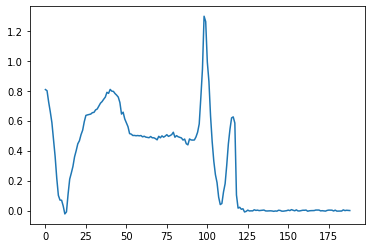

In [ ]:
generator.plot()